In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
df = pd.read_csv('./recipe_site_traffic_2212.csv')
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


# Data validation

In [50]:
df.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

it seems all of the data types are good except for servings let's change this to a number, but before we need to check if all the content contains only numbers

In [51]:
df['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

we have '4 as a snack' and '6 as a snack' we need to change them to 4 and 6

### servings column validation

In [52]:
df['servings'] = df['servings'].str.replace(' as a snack', '')
df['servings'].unique()

array(['6', '4', '1', '2'], dtype=object)

great all now let's change the data type

In [53]:
df['servings'] = df['servings'].astype(int)
df.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings          int32
high_traffic     object
dtype: object

### category column validation

In [54]:
df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

the Chicken Breast category is the same as 'Chicken'

In [55]:
df['category'] = df['category'].str.replace('Chicken Breast', 'Chicken')
df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert'],
      dtype=object)

### high_traffic column validation

In [56]:
df['high_traffic'].unique()

array(['High', nan], dtype=object)

nan values in high_traffic means not high

In [57]:
df['high_traffic'].fillna('Not-High', inplace=True)

C:\Users\ali\AppData\Local\Temp\ipykernel_12992\1267075681.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['high_traffic'].fillna('Not-High', inplace=True)


In [58]:
df['high_traffic'].unique()

array(['High', 'Not-High'], dtype=object)

## Missing Values

In [59]:
df.isna().sum()

recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

In [60]:
na_cols=df.columns[df.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(df[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(df),2)
mv

,Number_missing,Percentage_missing
calories,52,5.49
carbohydrate,52,5.49
sugar,52,5.49
protein,52,5.49


missing values occupy almost 5.5% of the data

Text(0.5, 1.0, 'Heatmap of missing values')

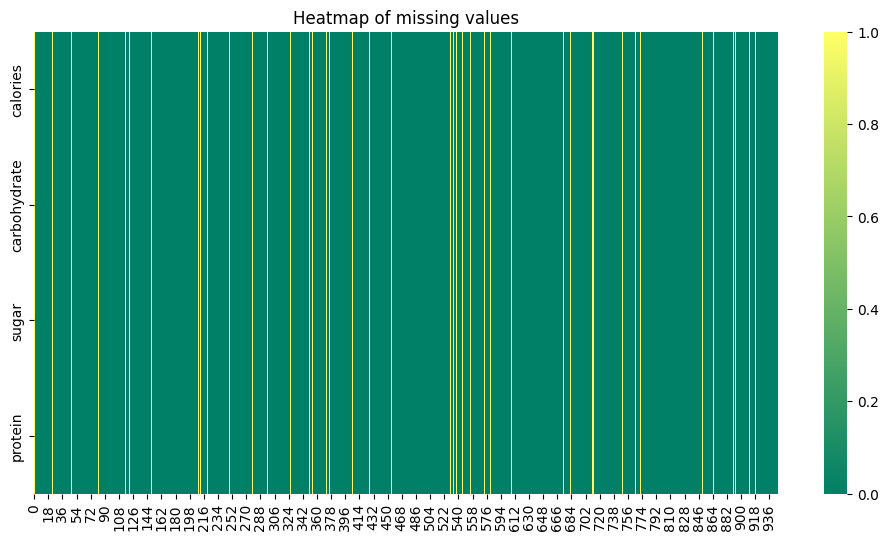

In [61]:
plt.figure(figsize=(12,6))
sns.heatmap(df[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')

the missing seems to be happening at the same time, let's find a way to impute this values mean or median, firstly we have to check if there is outliers

In [62]:
def outliers_iqr_count(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return column[(column < lower_bound) | (column > upper_bound)].count()

In [63]:
for na_col in na_cols:
    print(f"{na_col} outliers: {outliers_iqr_count(df[na_col])}")

calories outliers: 47
carbohydrate outliers: 58
sugar outliers: 79
protein outliers: 77


In [64]:
# for na_col in na_cols:
#     df[na_col].fillna(df['category'].map(imputation_dict[na_col]), inplace=True)
columns = ["calories", "carbohydrate", "sugar", "protein"]
df[columns] = df[columns].fillna(df[columns].median())

In [65]:
df.isna().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

In [66]:
df.drop(columns=['recipe'], axis=1, inplace=True)

In [67]:
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,288.55,21.48,4.55,10.80,Pork,6,High
1,35.48,38.56,0.66,0.92,Potato,4,High
2,914.28,42.68,3.09,2.88,Breakfast,1,Not-High
3,97.03,30.56,38.63,0.02,Beverages,4,High
4,27.05,1.85,0.80,0.53,Beverages,4,Not-High


# Exploratory Analysis

## Study the high_traffic target variable

<Axes: xlabel='high_traffic', ylabel='count'>

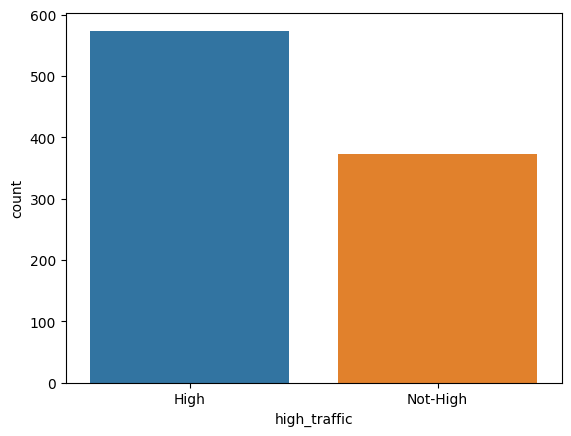

In [68]:
sns.countplot(df, x='high_traffic')

the high-traffic recipes occupies over **60%** of the data in contrast the not-high with almost **40%**.
the dataset is not that balanced in this case we need to take that into consideration when splitting the data for modeling, the website has higher high-traffic recipes than the others

## the relation with the target variable

<Axes: xlabel='category', ylabel='count'>

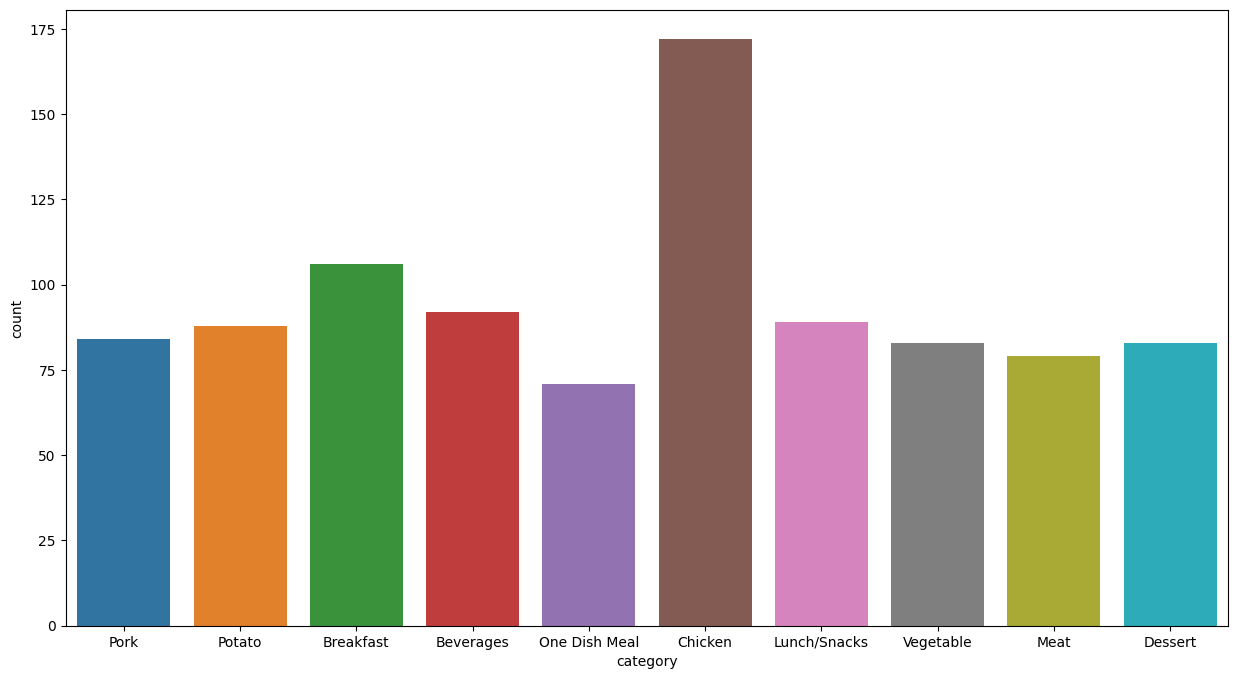

In [69]:
plt.figure(figsize=(15, 8))
sns.countplot(df, x='category')

Interesting, we can see that the categories are quite even except (almost between 75 and 100) for the Chicken category, this gives a clear idea about the distribution of the categories

<Axes: xlabel='category', ylabel='count'>

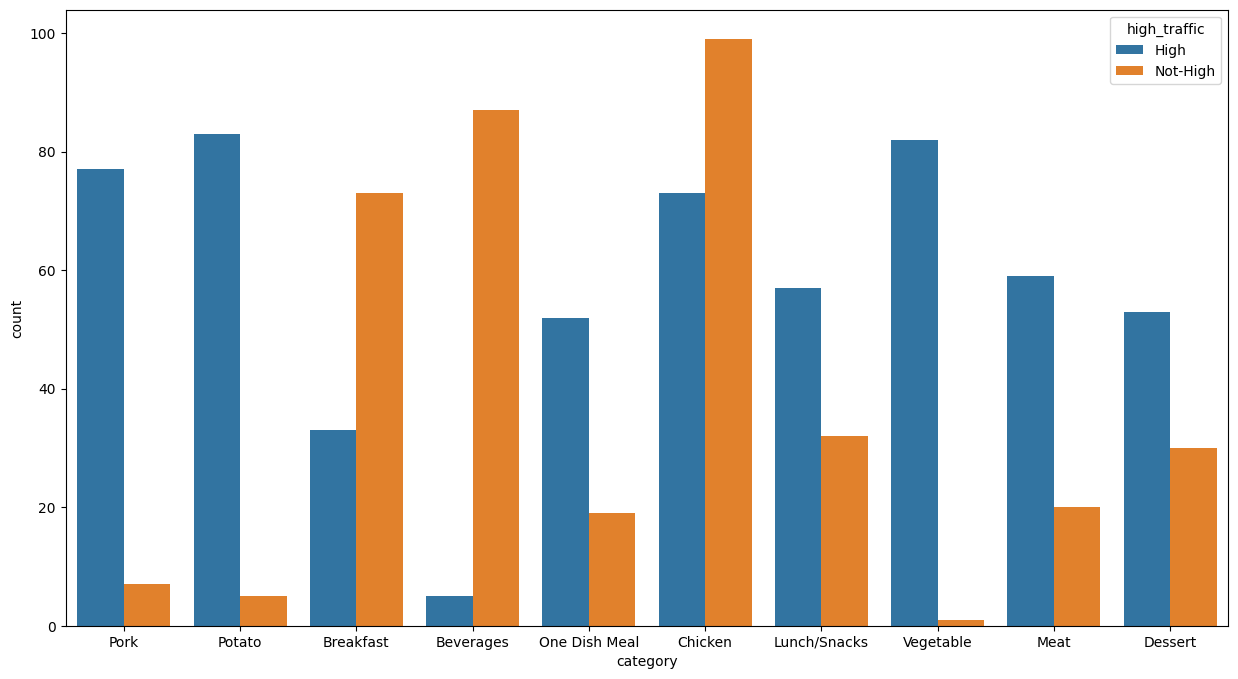

In [70]:
plt.figure(figsize=(15, 8))
sns.countplot(df, x='category', hue='high_traffic')

this gives an idea about the ranking, we can observe that Pork, Potato and Vegetables are popular, whereas Beverages and Breakfast aren't that popular

<Axes: xlabel='servings', ylabel='count'>

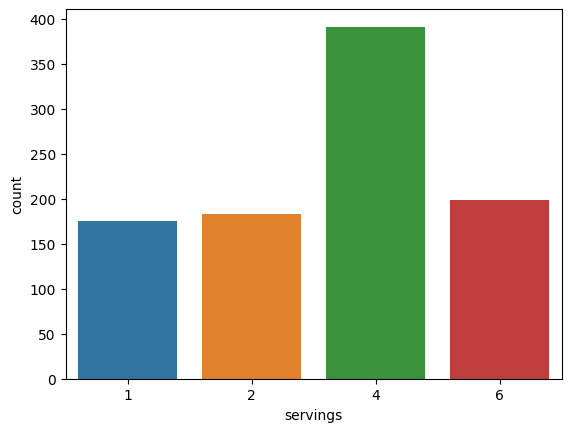

In [71]:

sns.countplot(df, x='servings')

we can see that recipes with 4 servings are more in this dataset and for 1,2 and 6 are the same

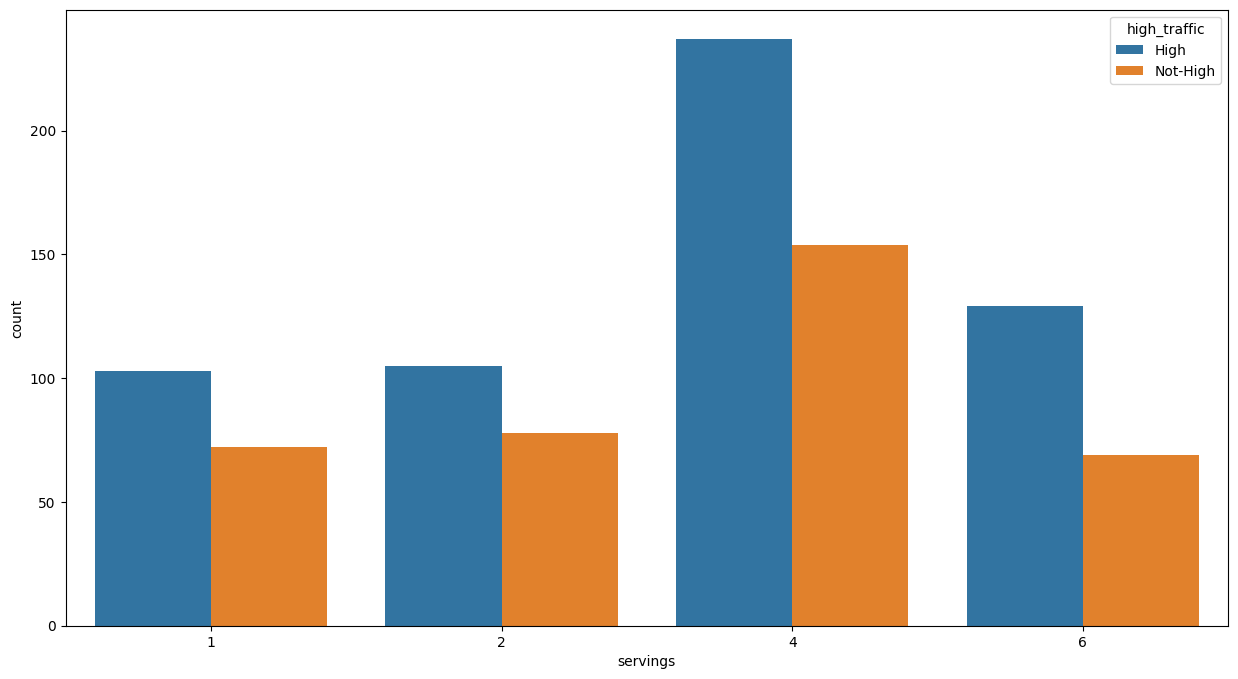

In [72]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(df, x='servings', hue='high_traffic')

it's always for every serving having higher propotion of high-traffic compared to not-high traffic

<Axes: xlabel='servings', ylabel='high_traffic'>

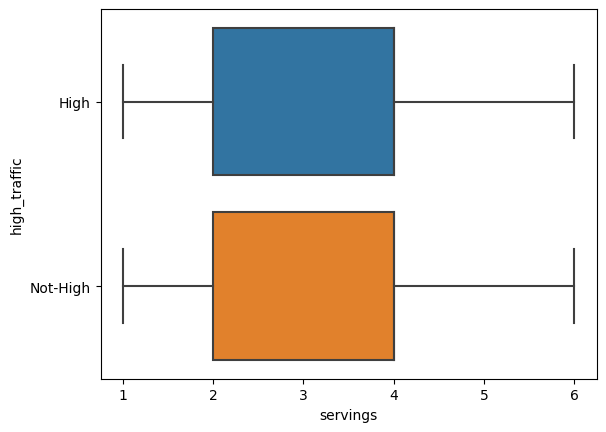

In [73]:
sns.boxplot(df, x='servings', y='high_traffic')

the distribution of the servings doesn't change when we compare the popularity

In [74]:
df.describe()

,calories,carbohydrate,sugar,protein,servings
count,947.000000,947.000000,947.000000,947.000000,947.000000
mean,427.846019,34.323464,8.799641,23.416283,3.477297
std,441.673556,42.836191,14.306785,35.486699,1.732741
min,0.140000,0.030000,0.010000,0.000000,1.000000
25%,114.410000,9.135000,1.795000,3.465000,2.000000
50%,288.550000,21.480000,4.550000,10.800000,4.000000
75%,576.225000,42.590000,9.285000,28.530000,4.000000
max,3633.160000,530.420000,148.750000,363.360000,6.000000


c:\Users\ali\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ali\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ali\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ali\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_in

<Axes: xlabel='protein', ylabel='Count'>

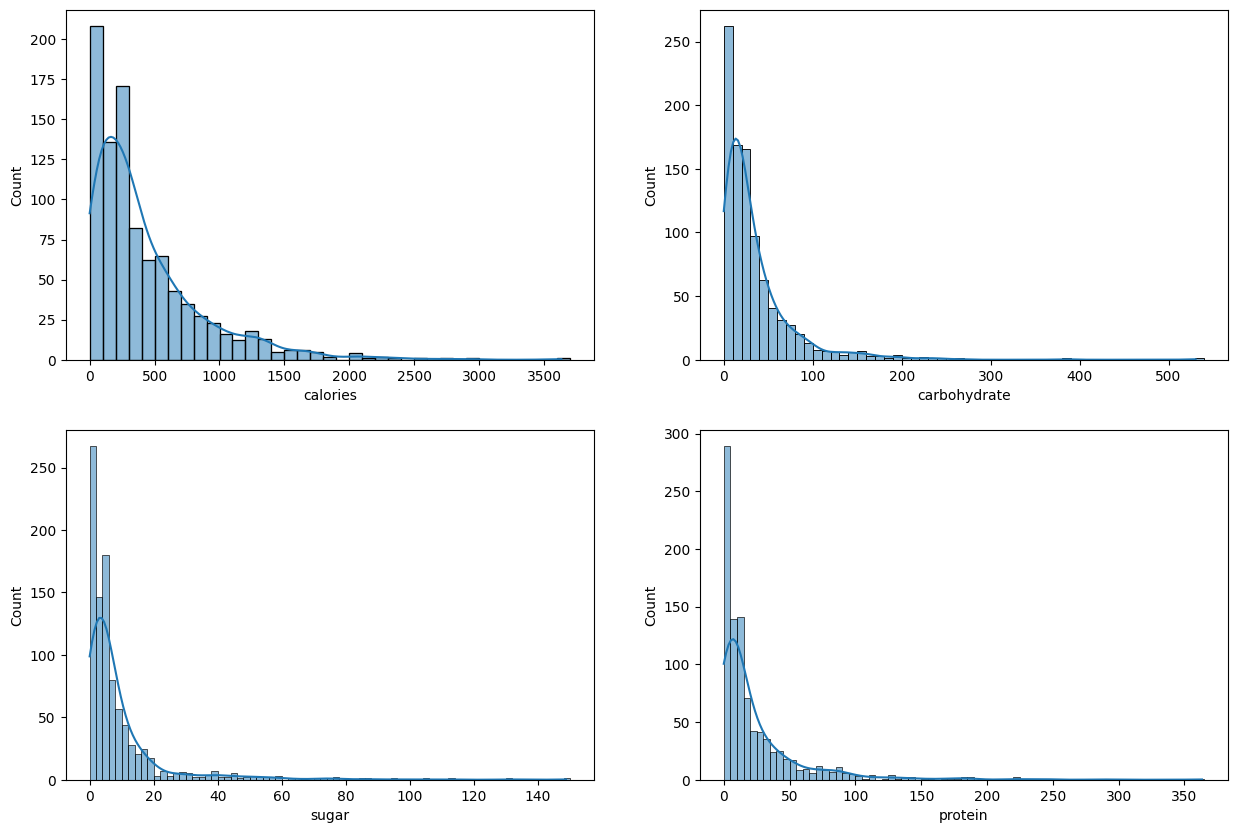

In [75]:
_, ax = plt.subplots(2,2, figsize=(15,10))
sns.histplot(df, x='calories',kde=True, ax=ax[0][0], binwidth=100)
sns.histplot(df, x='carbohydrate',kde=True, ax=ax[0][1], binwidth=10)
sns.histplot(df, x='sugar',kde=True, ax=ax[1][0], binwidth=2)
sns.histplot(df, x='protein',kde=True, ax=ax[1][1], binwidth=5)

most of our Nutritional Informations is right skewed with a lot of outliers and diffrent scaling, for modeling we need to do some preprocessing on it.

**Insights**:
* **calories**: between 0-500 for most of the recipes with a median of 296 and a maximum of 3633 calories
* **carbohydrate**: between 0-40 for most of the recipes with a median of 21 and a maximum of 530 carbohydrates
* **sugar**: between 0-6 for most of the recipes with a median of 4.4 and a maximum of 148 of sugar
* **protein**: between 0-20 for most of the recipes with a median of 11 and a maximum of 363 protein

# Model Development

In [76]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import time

In [77]:
df['high_traffic_binary'] = df['high_traffic'].map({'High': 1, 'Not-High': 0})
df = pd.get_dummies(df, columns=['category'])

In [78]:
X = df.drop(['high_traffic', 'high_traffic_binary'], axis=1)
y = df['high_traffic_binary']

### Dealing with extreme outliers

In [79]:
numerical_columns = ["calories", "carbohydrate", "sugar", "protein"]
Q1 = X[numerical_columns].quantile(0.25)
Q3 = X[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (3 * IQR)
upper_bound = Q3 + (3 * IQR)

def max_value(df, top):
    return np.where(df>top, top, df)

X[numerical_columns] = max_value(X[numerical_columns], upper_bound)

### Splitting & Preprocessing

In [80]:
scaler = MinMaxScaler()

X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

### Modeling

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

In [83]:
models = {
    "Logistic Regression": LogisticRegression(),
    "SCV": SVC(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(),
    "SGDC": SGDClassifier(),
    
}

SGDC_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
              'l1_ratio': [0, 0.15, 0.5, 0.85, 1],
              'max_iter': [1000, 5000, 10000],
            }

lr_grid = {
          'C': [0.01, 0.1, 1, 10, 100],
          'fit_intercept': [True, False],
          'class_weight': [None, 'balanced']
}

svc_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.25],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

rf_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [4, 8, 12, 16, 20],
    'min_samples_split': [2, 5, 10]
}
knn_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
nb_grid = {
    'var_smoothing': [1e-2, 1e-4, 1e-6, 1e-7, 1e-9, 1e-11]
}

boosting_grid = {
    'max_depth': [4, 8, 12],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.15]
}

grid = {
    "Logistic Regression": lr_grid,
    "SCV": svc_grid,
    "Random Forest": rf_grid,
    "KNN": knn_grid,
    "Naive Bayes": nb_grid,
    "XGBoost": boosting_grid,
    "SGDC": SGDC_grid,
}

In [84]:
scores = pd.DataFrame({'Model': models.keys(), 
                       'Accuracy': np.zeros(len(models)),
                       'Training Time': np.zeros(len(models))
                      })
model_best_params = models.copy()
i = 0

for key, model in models.items():
    print('Model: ', key)
    start = time.time()
    
    grid_search = GridSearchCV(estimator=model, param_grid=grid[key], cv=5, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    scores.iloc[i, 1] = grid_search.score(X_test, y_test)
    
    model_best_params[key] = grid_search.best_params_
    
    stop = time.time()
    
    scores.iloc[i, 2] = np.round((stop - start), 2)
    
    print('Model training time(s) : ', scores.iloc[i, 2])
    i += 1

Model:  Logistic Regression
Model training time(s) :  3.01
Model:  SCV
Model training time(s) :  0.41
Model:  Random Forest
Model training time(s) :  17.67
Model:  KNN
Model training time(s) :  0.23
Model:  Naive Bayes
Model training time(s) :  0.08
Model:  XGBoost
Model training time(s) :  4.23
Model:  SGDC
Model training time(s) :  0.8


In [85]:
scores.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Training Time
2,Random Forest,0.768421,17.67
0,Logistic Regression,0.764912,3.01
1,SCV,0.764912,0.41
6,SGDC,0.764912,0.80
5,XGBoost,0.747368,4.23
4,Naive Bayes,0.729825,0.08
3,KNN,0.722807,0.23


let's pick the SVC and LR

In [86]:
lr = LogisticRegression(**model_best_params['Logistic Regression'])
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

svm = SVC(**model_best_params['SCV'])
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

## Model evaluation

Here, we present a comparison between the two fitted models. In this scenario, prioritizing precision over accuracy is more appropriate. While accuracy provides an overall assessment of the model's performance, our focus, as per my manager's request, is specifically on studying the "high" label (denoted by 1). Additionally, due to the imperfect balance in my dataset, the utility of accuracy is diminished.

Our objective is to minimize the risk of showcasing unpopular recipes, as indicated in my manager's email. Hence, we aim to avoid False Positive predictions, where an unpopular recipe is incorrectly labeled as popular. Therefore, the precision score is valuable in this context as it considers these instances of False Positive predictions, serving as our primary metric of interest.

While ensuring a decent recall is always beneficial, accounting for False Negatives (popular recipes labeled as unpopular), our main emphasis remains on precision. To strike a balance between precision and recall, we turn to the F1 score, which provides a harmonic mean of these two metrics, offering a comprehensive evaluation.

*****LOGISTIC REGRESSION MODEL*****
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       112
           1       0.83      0.77      0.80       173

    accuracy                           0.76       285
   macro avg       0.76      0.76      0.76       285
weighted avg       0.77      0.76      0.77       285



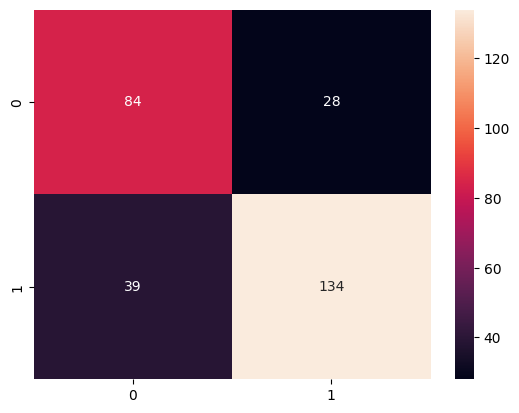

In [87]:
print("*****LOGISTIC REGRESSION MODEL*****")
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt=".0f")
print(classification_report(y_test, y_pred_lr))

*****SVM*****
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       112
           1       0.83      0.77      0.80       173

    accuracy                           0.76       285
   macro avg       0.76      0.76      0.76       285
weighted avg       0.77      0.76      0.77       285



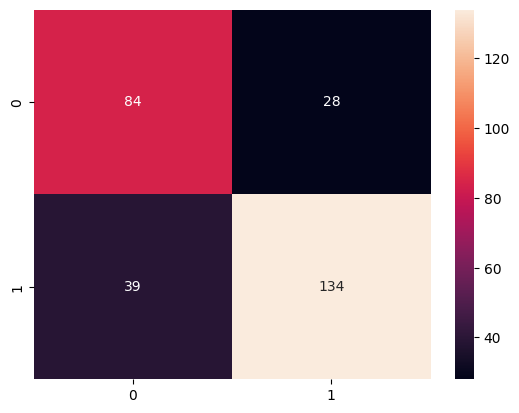

In [88]:
print("*****SVM*****")
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt=".0f")
print(classification_report(y_test, y_pred_svm))